# Определение возраста покупателей

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста

# Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.shape

(7591, 2)

Всего у нас 7591 изображений. Датафрейм хранит информацию о названии файла и возрасте человека на этой фотографии

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим на распределение возраста

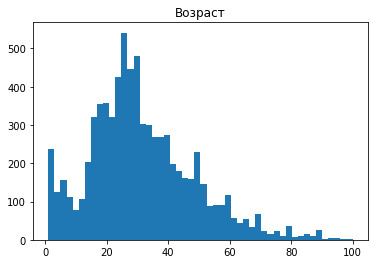

In [6]:
plt.hist(labels['real_age'], bins=50)
plt.title('Возраст')
plt.show()

Преобладают люди с возрастом 18 - 30 лет. Также есть немало детей до 10 лет

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


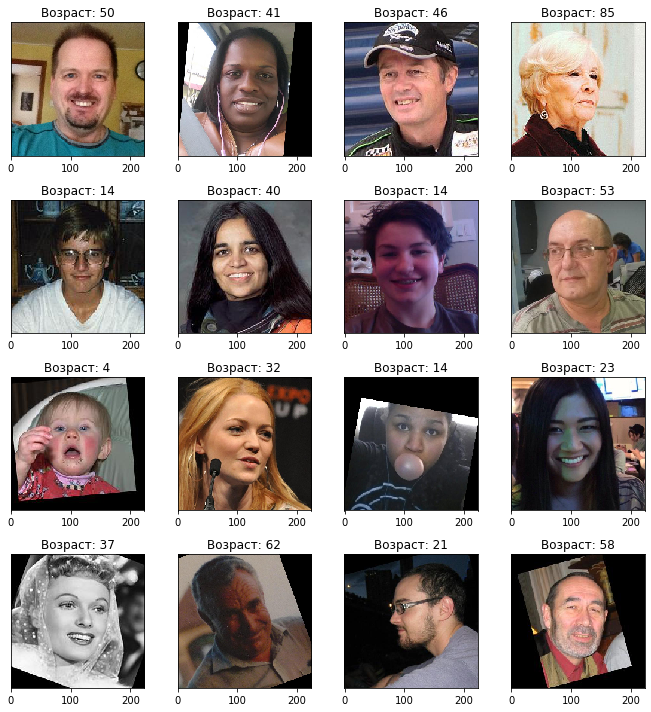

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Все изображения сжаты до одинакового размера 224 на 224 пикселей. Фотографии преимущественно цветные, но присутсвуют также черно-белые изображения. Как видно, аугментация уже сделана. Основным определителем возраста является лицо человека. Однако на некоторых фотографиях лицо человека показано в профиль, в других - лицо перекрыто объектами (очки, рука, микрофон, жвачка и пр.)

# Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

optimizer = Adam(lr=0.0001)

backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
	subset='training')
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
	subset='validation')
    return test_gen_flow

def create_model(input_shape):
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=100, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/100
2022-02-07 10:29:12.400295: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-07 10:29:16.248829: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 111s - loss: 256.4245 - mae: 11.5406 - val_loss: 457.6936 - val_mae: 16.3072
Epoch 2/100
178/178 - 39s - loss: 72.2068 - mae: 6.4759 - val_loss: 542.1049 - val_mae: 18.1387
Epoch 3/100
178/178 - 39s - loss: 46.5051 - mae: 5.1910 - val_loss: 216.2263 - val_mae: 11.1535
Epoch 4/100
178/178 - 39s - loss: 32.9733 - mae: 4.3690 - val_loss: 118.2098 - val_mae: 8.2607
Epoch 5/100
178/178 - 39s - loss: 25.2936 - mae: 3.8497 - val_loss: 74.3278 - val_mae: 6.4369
Epoch 6/100
178/178 - 39s - loss: 20.2491 - mae: 3.4593 - val_loss: 64.1714 - val_mae: 5.9927
Epoch 7/100
178/178 - 39s - loss: 15.5916 - mae: 2.9988 - val_loss: 63.1232 - val_mae: 5.9117
Epoch 8/100
178/178 - 39s - loss: 12.6833 - mae: 2.6919 - val_loss: 63.4533 - val_mae: 5.8069
Epoch 9/100
178/178 - 39s - loss: 11.0058 - mae: 2.5304 - val_loss: 69.5835 - val_mae: 6.4075
Epoch 10/100
178/178 - 39s - loss: 9.8463 - mae: 2.3540 - val_loss: 66.6529 - val_mae: 6.2166
Epoch 11/100
178/178 - 38s - loss: 8.5691 - mae: 2.2011 - val_loss: 64.5062 - val_mae: 6.1265
Epoch 12/100
178/178 - 39s - loss: 8.6177 - mae: 2.2188 - val_loss: 62.3552 - val_mae: 6.0053
Epoch 13/100
178/178 - 39s - loss: 7.8472 - mae: 2.1091 - val_loss: 60.8194 - val_mae: 5.7414
Epoch 14/100
178/178 - 39s - loss: 6.6127 - mae: 1.9476 - val_loss: 68.5074 - val_mae: 6.0759
Epoch 15/100
178/178 - 38s - loss: 6.0272 - mae: 1.8585 - val_loss: 59.0571 - val_mae: 5.7326
Epoch 16/100
178/178 - 39s - loss: 6.1176 - mae: 1.8369 - val_loss: 56.6518 - val_mae: 5.5866
Epoch 17/100
178/178 - 39s - loss: 6.0107 - mae: 1.8288 - val_loss: 81.5074 - val_mae: 6.6808
Epoch 18/100
178/178 - 39s - loss: 6.0352 - mae: 1.8471 - val_loss: 60.7159 - val_mae: 5.8072
Epoch 19/100
178/178 - 39s - loss: 6.8725 - mae: 1.9692 - val_loss: 61.5095 - val_mae: 5.8518
Epoch 20/100
178/178 - 39s - loss: 7.3289 - mae: 2.0498 - val_loss: 65.4473 - val_mae: 6.0080
Epoch 21/100
178/178 - 39s - loss: 7.0873 - mae: 1.9989 - val_loss: 57.5520 - val_mae: 5.5671
Epoch 22/100
178/178 - 39s - loss: 6.8689 - mae: 1.9746 - val_loss: 61.1215 - val_mae: 5.7593
Epoch 23/100
178/178 - 39s - loss: 6.8386 - mae: 1.9579 - val_loss: 78.0478 - val_mae: 6.8654
Epoch 24/100
178/178 - 39s - loss: 6.8723 - mae: 1.9900 - val_loss: 60.2998 - val_mae: 5.6120
Epoch 25/100
178/178 - 38s - loss: 6.8164 - mae: 1.9887 - val_loss: 57.8269 - val_mae: 5.5491
Epoch 26/100
178/178 - 39s - loss: 6.8233 - mae: 1.9811 - val_loss: 55.6127 - val_mae: 5.4860
Epoch 27/100
178/178 - 39s - loss: 6.1557 - mae: 1.8420 - val_loss: 61.3322 - val_mae: 5.7666
Epoch 28/100
178/178 - 39s - loss: 5.6618 - mae: 1.7806 - val_loss: 67.0718 - val_mae: 6.2614
Epoch 29/100
178/178 - 39s - loss: 5.4807 - mae: 1.7444 - val_loss: 63.0271 - val_mae: 5.8039
Epoch 30/100
178/178 - 39s - loss: 4.9654 - mae: 1.6650 - val_loss: 59.9778 - val_mae: 5.6469
Epoch 31/100
178/178 - 39s - loss: 4.7906 - mae: 1.6362 - val_loss: 63.9226 - val_mae: 5.8927
Epoch 32/100
178/178 - 39s - loss: 4.9480 - mae: 1.6860 - val_loss: 62.5234 - val_mae: 5.9005
Epoch 33/100
178/178 - 39s - loss: 5.0337 - mae: 1.6829 - val_loss: 59.2316 - val_mae: 5.8066
Epoch 34/100
178/178 - 39s - loss: 4.7625 - mae: 1.6206 - val_loss: 58.9643 - val_mae: 5.6859
Epoch 35/100
178/178 - 39s - loss: 4.9256 - mae: 1.6545 - val_loss: 58.9120 - val_mae: 5.5826
Epoch 36/100
178/178 - 39s - loss: 4.2571 - mae: 1.5457 - val_loss: 55.6348 - val_mae: 5.4270
Epoch 37/100
178/178 - 39s - loss: 4.4495 - mae: 1.5902 - val_loss: 55.3429 - val_mae: 5.5325
Epoch 38/100
178/178 - 38s - loss: 4.2182 - mae: 1.5302 - val_loss: 63.9224 - val_mae: 6.0146
Epoch 39/100
178/178 - 39s - loss: 4.5287 - mae: 1.5867 - val_loss: 56.0009 - val_mae: 5.5010
Epoch 40/100
178/178 - 39s - loss: 4.3359 - mae: 1.5643 - val_loss: 59.3876 - val_mae: 5.7781
Epoch 41/100
178/178 - 39s - loss: 4.2449 - mae: 1.5564 - val_loss: 62.8320 - val_mae: 5.9530
Epoch 42/100
178/178 - 39s - loss: 4.5174 - mae: 1.5808 - val_loss: 60.2554 - val_mae: 5.7975
Epoch 43/100
178/178 - 39s - loss: 4.3729 - mae: 1.5547 - val_loss: 57.2495 - val_mae: 5.4950
Epoch 44/100
178/178 - 41s - loss: 4.2882 - mae: 1.5570 - val_loss: 58.0677 - val_mae: 5.5735
Epoch 45/100
178/178 - 41s - loss: 4.0159 - mae: 1.4980 - val_loss: 57.9685 - val_mae: 5.6851
Epoch 46/100
178/178 - 40s - loss: 3.6464 - mae: 1.4239 - val_loss: 58.6311 - val_mae: 5.7404
Epoch 47/100
178/178 - 40s - loss: 3.4435 - mae: 1.4003 - val_loss: 56.9159 - val_mae: 5.5002
Epoch 48/100
178/178 - 40s - loss: 3.6265 - mae: 1.4291 - val_loss: 68.7137 - val_mae: 6.2775
Epoch 49/100
178/178 - 40s - loss: 11.6344 - mae: 2.5051 - val_loss: 63.9658 - val_mae: 5.9671
Epoch 50/100
178/178 - 40s - loss: 17.6855 - mae: 2.9856 - val_loss: 77.6602 - val_mae: 6.5800
Epoch 51/100
178/178 - 40s - loss: 9.1909 - mae: 2.2766 - val_loss: 59.1421 - val_mae: 5.6524
Epoch 52/100
178/178 - 40s - loss: 4.8774 - mae: 1.6297 - val_loss: 60.6778 - val_mae: 5.5627
Epoch 53/100
178/178 - 41s - loss: 2.8203 - mae: 1.2511 - val_loss: 56.1339 - val_mae: 5.4732
Epoch 54/100
178/178 - 40s - loss: 1.8856 - mae: 1.0011 - val_loss: 58.4077 - val_mae: 5.6322
Epoch 55/100
178/178 - 39s - loss: 1.3669 - mae: 0.8618 - val_loss: 54.3026 - val_mae: 5.3968
Epoch 56/100
178/178 - 39s - loss: 1.0669 - mae: 0.7649 - val_loss: 55.7745 - val_mae: 5.4878
Epoch 57/100
178/178 - 39s - loss: 0.9013 - mae: 0.7004 - val_loss: 53.7695 - val_mae: 5.3754
Epoch 58/100
178/178 - 39s - loss: 0.8932 - mae: 0.6951 - val_loss: 54.6714 - val_mae: 5.4397
Epoch 59/100
178/178 - 39s - loss: 0.9608 - mae: 0.7091 - val_loss: 54.9730 - val_mae: 5.4723
Epoch 60/100
178/178 - 39s - loss: 1.2243 - mae: 0.7912 - val_loss: 54.6142 - val_mae: 5.4556
Epoch 61/100
178/178 - 39s - loss: 1.5134 - mae: 0.9044 - val_loss: 54.0525 - val_mae: 5.3968
Epoch 62/100
178/178 - 39s - loss: 2.1771 - mae: 1.0824 - val_loss: 56.8020 - val_mae: 5.5742
Epoch 63/100
178/178 - 39s - loss: 2.4063 - mae: 1.1304 - val_loss: 60.3649 - val_mae: 5.6351
Epoch 64/100
178/178 - 39s - loss: 2.4780 - mae: 1.1677 - val_loss: 58.6660 - val_mae: 5.5920
Epoch 65/100
178/178 - 39s - loss: 2.5842 - mae: 1.1958 - val_loss: 56.7154 - val_mae: 5.5127
Epoch 66/100
178/178 - 39s - loss: 2.9078 - mae: 1.2670 - val_loss: 57.1118 - val_mae: 5.5111
Epoch 67/100
178/178 - 39s - loss: 2.9131 - mae: 1.2704 - val_loss: 59.5275 - val_mae: 5.7778
Epoch 68/100
178/178 - 39s - loss: 2.6320 - mae: 1.2030 - val_loss: 55.1595 - val_mae: 5.4269
Epoch 69/100
178/178 - 39s - loss: 2.8371 - mae: 1.2588 - val_loss: 65.1870 - val_mae: 5.7875
Epoch 70/100
178/178 - 39s - loss: 3.2729 - mae: 1.3433 - val_loss: 55.6983 - val_mae: 5.4831
Epoch 71/100
178/178 - 39s - loss: 3.0584 - mae: 1.3098 - val_loss: 57.9987 - val_mae: 5.5732
Epoch 72/100
178/178 - 39s - loss: 3.0527 - mae: 1.2907 - val_loss: 59.7546 - val_mae: 5.6526
Epoch 73/100
178/178 - 39s - loss: 2.8560 - mae: 1.2637 - val_loss: 56.8712 - val_mae: 5.5261
Epoch 74/100
178/178 - 39s - loss: 2.8356 - mae: 1.2551 - val_loss: 59.5365 - val_mae: 5.5496
Epoch 75/100
178/178 - 39s - loss: 2.7485 - mae: 1.2181 - val_loss: 63.0290 - val_mae: 5.8956
Epoch 76/100
178/178 - 39s - loss: 2.5904 - mae: 1.2008 - val_loss: 54.3822 - val_mae: 5.3812
Epoch 77/100
178/178 - 39s - loss: 2.0808 - mae: 1.0757 - val_loss: 54.8387 - val_mae: 5.3862
Epoch 78/100
178/178 - 39s - loss: 2.8562 - mae: 1.2719 - val_loss: 57.9455 - val_mae: 5.4940
Epoch 79/100
178/178 - 39s - loss: 2.9430 - mae: 1.3070 - val_loss: 57.5338 - val_mae: 5.4206
Epoch 80/100
178/178 - 39s - loss: 2.9728 - mae: 1.2891 - val_loss: 54.0134 - val_mae: 5.3668
Epoch 81/100
178/178 - 39s - loss: 2.4209 - mae: 1.1650 - val_loss: 53.7332 - val_mae: 5.3164
Epoch 82/100
178/178 - 39s - loss: 2.9615 - mae: 1.2614 - val_loss: 65.3523 - val_mae: 5.8620
Epoch 83/100
178/178 - 39s - loss: 3.1361 - mae: 1.3427 - val_loss: 59.7193 - val_mae: 5.5849
Epoch 84/100
178/178 - 39s - loss: 2.8248 - mae: 1.2466 - val_loss: 56.0382 - val_mae: 5.5092
Epoch 85/100
178/178 - 39s - loss: 5.5798 - mae: 1.6346 - val_loss: 104.1588 - val_mae: 7.5830
Epoch 86/100
178/178 - 39s - loss: 10.1892 - mae: 2.2943 - val_loss: 64.9791 - val_mae: 5.8091
Epoch 87/100
178/178 - 39s - loss: 3.9329 - mae: 1.4866 - val_loss: 58.6314 - val_mae: 5.4984
Epoch 88/100
178/178 - 39s - loss: 2.9929 - mae: 1.2331 - val_loss: 69.4758 - val_mae: 5.9849
Epoch 89/100
178/178 - 39s - loss: 2.2630 - mae: 1.1215 - val_loss: 56.4413 - val_mae: 5.4820
Epoch 90/100
178/178 - 39s - loss: 1.3039 - mae: 0.8426 - val_loss: 54.8581 - val_mae: 5.3910
Epoch 91/100
178/178 - 39s - loss: 0.9259 - mae: 0.6989 - val_loss: 54.4837 - val_mae: 5.4208
Epoch 92/100
178/178 - 39s - loss: 0.6621 - mae: 0.5937 - val_loss: 55.9864 - val_mae: 5.3899
Epoch 93/100
178/178 - 39s - loss: 0.5845 - mae: 0.5623 - val_loss: 54.0914 - val_mae: 5.3730
Epoch 94/100
178/178 - 39s - loss: 0.5300 - mae: 0.5266 - val_loss: 54.6739 - val_mae: 5.3204
Epoch 95/100
178/178 - 39s - loss: 0.5447 - mae: 0.5305 - val_loss: 54.6655 - val_mae: 5.3415
Epoch 96/100
178/178 - 39s - loss: 0.6377 - mae: 0.5737 - val_loss: 53.9182 - val_mae: 5.2825
Epoch 97/100
178/178 - 39s - loss: 0.7572 - mae: 0.6199 - val_loss: 54.2434 - val_mae: 5.4238
Epoch 98/100
178/178 - 39s - loss: 0.8585 - mae: 0.6608 - val_loss: 53.9449 - val_mae: 5.2997
Epoch 99/100
178/178 - 39s - loss: 0.9867 - mae: 0.7069 - val_loss: 56.6833 - val_mae: 5.3827
Epoch 100/100
178/178 - 39s - loss: 1.0844 - mae: 0.7420 - val_loss: 54.3549 - val_mae: 5.4127

```

# Анализ модели

Код обучения модели был запущен на сервере с графической картой (GPU) Yandex Compute Cloud. Сначала были загружены изображения и поделены на тренировочную и валидационную выборки в соотношении 3:1. Для тренировочных изображений я добавил аугментацию поворота по горизонтальной оси, чтобы в два раза увеличить тренировочную выборку.  
Для архитектуры нейронной сети я использовал алгоритм ResNet и в конце добавил 2 полносвязных слоя с 64-мя нейронами в каждом. Модель была обучена на 100 эпохах с градиентным спуском Adam и шагом обучения равным 0.0001. В итоге, наименьший показатель метрики mean absolute error на валидационной выборке составил 5.28 на 96-ой эпохе.  
Полученная модель позволит бизнесу с высокой точностью определить возраст клиента, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. Также для того, чтобы контролировать добросовестность кассиров при продаже алкоголя.